# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = []
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8139 - accuracy: 0.7295

947/947 [==============================] - 5702s 6s/step - loss: 0.8139 - accuracy: 0.7295 - val_loss: 0.8957 - val_accuracy: 0.7237
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.7581

947/947 [==============================] - 5283s 6s/step - loss: 0.6979 - accuracy: 0.7581 - val_loss: 0.6730 - val_accuracy: 0.7648
Epoch 3/200
947/947 [==============================] - 4882s 5s/step - loss: 0.6493 - accuracy: 0.7761 - val_loss: 0.7863 - val_accuracy: 0.7609
Epoch 4/200
947/947 [==============================] - 4846s 5s/step - loss: 0.6213 - accuracy: 0.7849 - val_loss: 3.4814 - val_accuracy: 0.7136
Epoch 5/200
947/947 [==============================] - 4836s 5s/step - loss: 0.6028 - accuracy: 0.7887 - val_loss: 1.0442 - val_accuracy: 0.7356
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5808 - accuracy: 0.7963

947/947 [==============================] - 5232s 6s/step - loss: 0.5808 - accuracy: 0.7963 - val_loss: 0.5752 - val_accuracy: 0.8032
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5483 - accuracy: 0.8060

947/947 [==============================] - 5243s 6s/step - loss: 0.5483 - accuracy: 0.8060 - val_loss: 0.5419 - val_accuracy: 0.8020
Epoch 8/200
947/947 [==============================] - 4937s 5s/step - loss: 0.5289 - accuracy: 0.8135 - val_loss: 0.5992 - val_accuracy: 0.7954
Epoch 9/200
947/947 [==============================] - 4883s 5s/step - loss: 0.5403 - accuracy: 0.8103 - val_loss: 0.6039 - val_accuracy: 0.7880
Epoch 10/200
947/947 [==============================] - 4869s 5s/step - loss: 0.5077 - accuracy: 0.8190 - val_loss: 0.5733 - val_accuracy: 0.7938
Epoch 11/200
947/947 [==============================] - 4878s 5s/step - loss: 0.4809 - accuracy: 0.8289 - val_loss: 1.2146 - val_accuracy: 0.7566
Epoch 12/200
947/947 [==============================] - 4874s 5s/step - loss: 0.5041 - accuracy: 0.8210 - val_loss: 0.6015 - val_accuracy: 0.7961
Epoch 13/200
947/947 [==============================] - 4854s 5s/step - loss: 0.4522 - accuracy: 0.8376 - val_loss: 0.5446 - val_accuracy: 

947/947 [==============================] - 5445s 6s/step - loss: 0.4314 - accuracy: 0.8464 - val_loss: 0.4890 - val_accuracy: 0.8267
Epoch 16/200
947/947 [==============================] - 4919s 5s/step - loss: 0.4178 - accuracy: 0.8496 - val_loss: 0.5124 - val_accuracy: 0.8180
Epoch 17/200
947/947 [==============================] - 5046s 5s/step - loss: 0.4220 - accuracy: 0.8477 - val_loss: 0.7475 - val_accuracy: 0.7475
Epoch 18/200
947/947 [==============================] - ETA: 0s - loss: 0.4128 - accuracy: 0.8500

947/947 [==============================] - 5284s 6s/step - loss: 0.4128 - accuracy: 0.8500 - val_loss: 0.4651 - val_accuracy: 0.8332
Epoch 19/200
947/947 [==============================] - 4960s 5s/step - loss: 0.3812 - accuracy: 0.8627 - val_loss: 0.4721 - val_accuracy: 0.8328
Epoch 20/200
947/947 [==============================] - 5003s 5s/step - loss: 0.3709 - accuracy: 0.8644 - val_loss: 0.4668 - val_accuracy: 0.8358
Epoch 21/200
947/947 [==============================] - 4848s 5s/step - loss: 0.3606 - accuracy: 0.8691 - val_loss: 0.4864 - val_accuracy: 0.8319
Epoch 22/200
947/947 [==============================] - 4841s 5s/step - loss: 0.4464 - accuracy: 0.8434 - val_loss: 1.0468 - val_accuracy: 0.7253
Epoch 23/200
947/947 [==============================] - 4855s 5s/step - loss: 0.4878 - accuracy: 0.8301 - val_loss: 0.5192 - val_accuracy: 0.8143
Epoch 24/200
947/947 [==============================] - 4846s 5s/step - loss: 0.3864 - accuracy: 0.8627 - val_loss: 0.4902 - val_accuracy

947/947 [==============================] - 5260s 6s/step - loss: 0.2979 - accuracy: 0.8910 - val_loss: 0.4543 - val_accuracy: 0.8444
Epoch 32/200
947/947 [==============================] - 4875s 5s/step - loss: 0.2968 - accuracy: 0.8918 - val_loss: 0.4936 - val_accuracy: 0.8436
Epoch 33/200
947/947 [==============================] - 4854s 5s/step - loss: 0.2708 - accuracy: 0.9023 - val_loss: 0.9123 - val_accuracy: 0.7970
Epoch 34/200
947/947 [==============================] - 4930s 5s/step - loss: 0.2638 - accuracy: 0.9040 - val_loss: 0.9535 - val_accuracy: 0.8249
Epoch 35/200
947/947 [==============================] - 4999s 5s/step - loss: 0.2508 - accuracy: 0.9066 - val_loss: 0.4825 - val_accuracy: 0.8379
Epoch 36/200
947/947 [==============================] - 4886s 5s/step - loss: 0.3025 - accuracy: 0.8909 - val_loss: 2.6085 - val_accuracy: 0.8243
Epoch 37/200
947/947 [==============================] - 4902s 5s/step - loss: 0.2429 - accuracy: 0.9104 - val_loss: 1.4744 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 490s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9717869680623342,
 'basal cell carcinoma': 0.9838711897482799,
 'dermatofibroma': 0.9647550776583035,
 'melanoma': 0.9365328377933768,
 'nevus': 0.9719104249566141,
 'pigmented benign keratosis': 0.9868087222582793,
 'seborrheic keratosis': 0.9519364397625519,
 'solar lentigo': 0.961572110067513,
 'squamous cell carcinoma': 0.968322584979175,
 'vascular lesion': 0.9997034911525586}

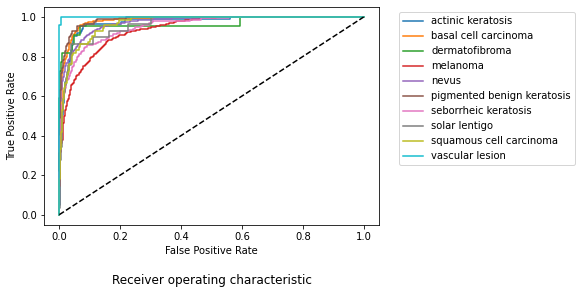

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

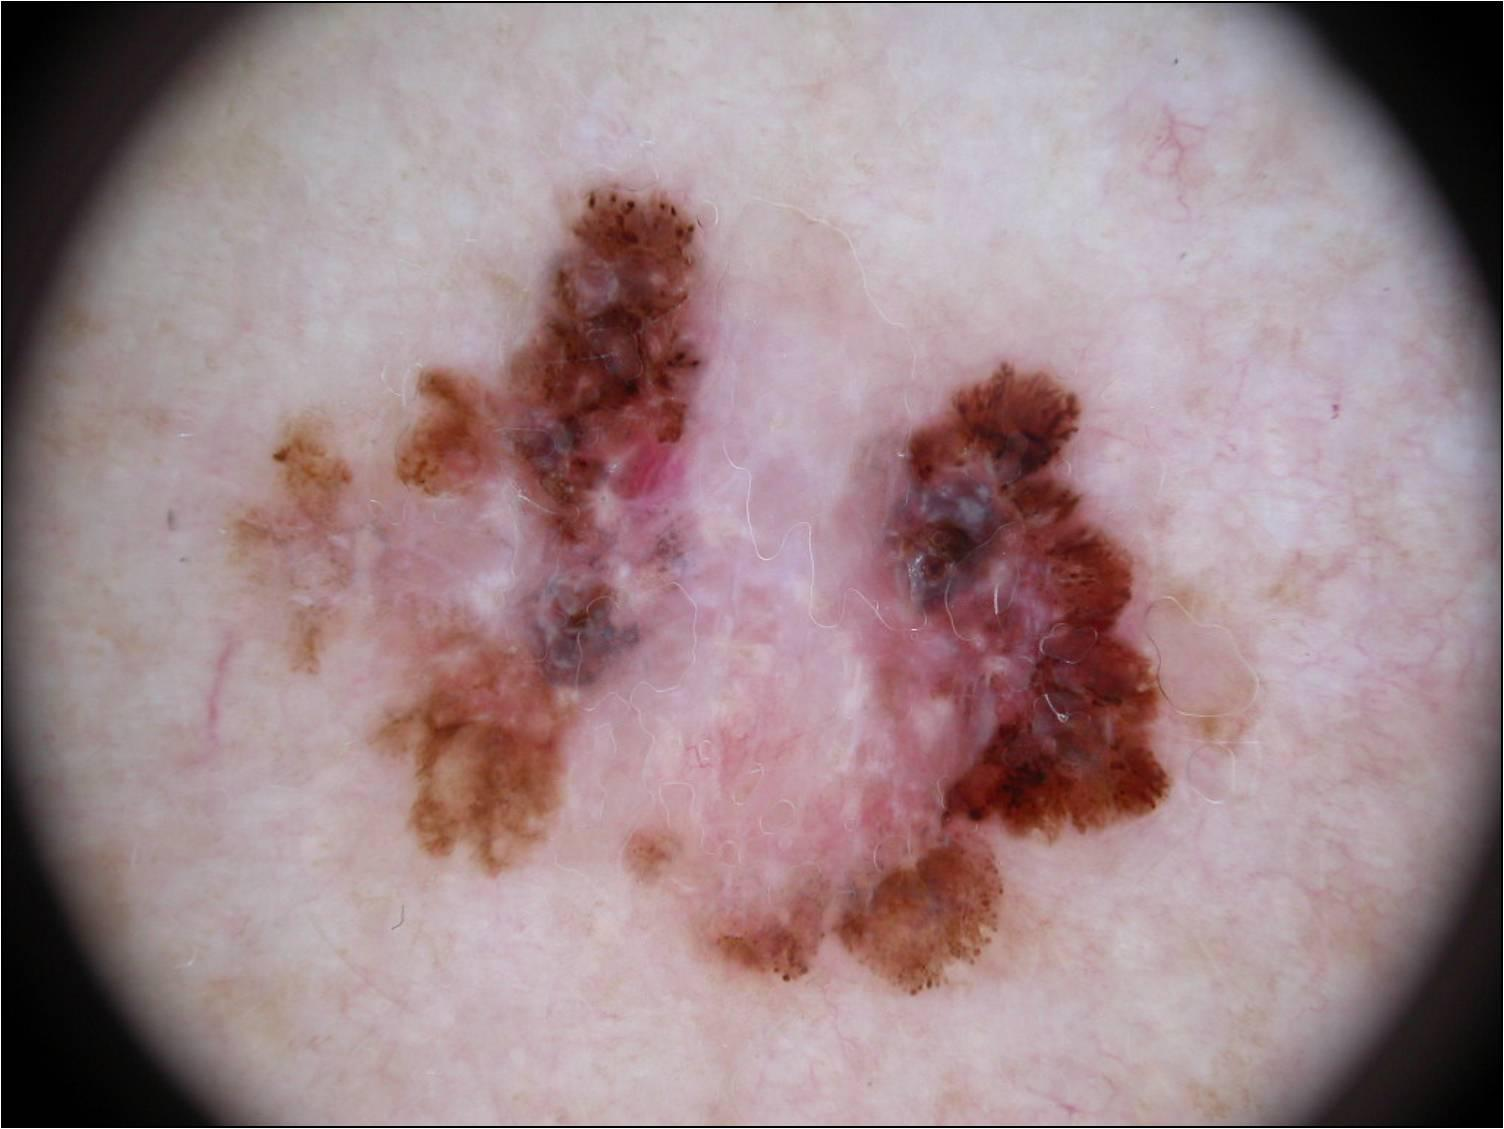

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'conv_7b')

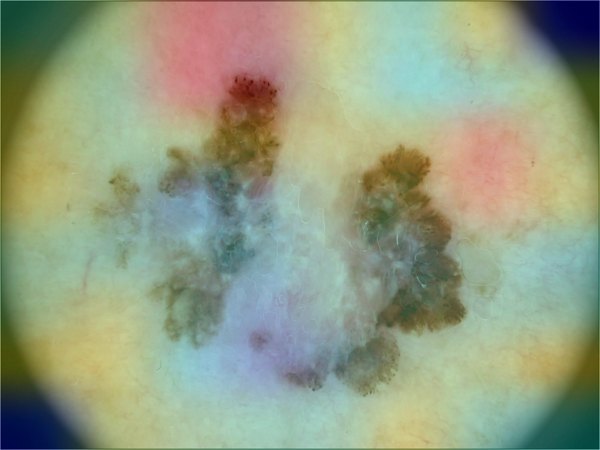

In [23]:
display_gradcam(melanoma_im_path, heatmap)